# **Libraries and Dependencies**

In [ ]:
! pip install pyDOE #Latin Hypercube Sampling
! pip install plotting
! pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [ ]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Physics-informed Neural Networks**

In [ ]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer = torch.nn.Linear(layers[i], layers[i+1])
            torch.nn.init.xavier_normal_(layer.weight.data, gain=1.0)
            torch.nn.init.zeros_(layer.bias.data)

            layer_list.append(
                ('layer_%d' % i, layer)
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            # layer_list.append(('dropout_%d'%i, torch.nn.Dropout(0.005)))

            # layer_list.append(('normalisation_%d' % i, torch.nn.BatchNorm1d(layers[i+1])))
            # layer_list.append(('normalisation_%d' % i, torch.nn.layerNorm(layers[i+1])))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out


In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=10000, 
            max_eval=10000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f

    def l1_loss(self):
        l1_loss = torch.nn.L1Loss(size_average=False)
        reg_loss=0
        for param in self.dnn.parameters():
            reg_loss+=l1_loss(param)

        return reg_loss
            
    def loss_func(self):
        global error_list
        
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        # if self.iter % 100 == 0:
        print(
            'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
        )
        
        # print('Error u: %e' % (error_u))
        return loss
    
    def fitness_func(self, solution, sol_idx):
        predictions = pygad.torchga.predict(model=self.dnn, solution=solution, data=data_inputs)
        

    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# **Configurations**

In [ ]:
nu = 0.01/np.pi
noise = 0.0        

error_list = []

N_u = 100
N_f = 10000
n_neurs = 20
layers = [2, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, 1]

data = scipy.io.loadmat('/content/drive/MyDrive/SEM - 7/BTP/data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)
mu = X_star.mean()
var = X_star.var()    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
# X_f_train = (lhs(2, N_f) - mu) / var

X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

#u_pred, f_pred = model.predict(X_star)

#error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#print('Error u: %e' % (error_u))                     

#U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
#Error = np.abs(Exact - U_pred)

# **Training**

In [ ]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star)

In [ ]:
%%time

model.train()

Iter 1, Loss: 3.53286e-01, Loss_u: 3.49547e-01, Loss_f: 3.73928e-03
Iter 2, Loss: 3.32104e-01, Loss_u: 3.31422e-01, Loss_f: 6.81739e-04
Iter 3, Loss: 2.64937e-01, Loss_u: 2.48126e-01, Loss_f: 1.68109e-02
Iter 4, Loss: 2.32750e-01, Loss_u: 2.11026e-01, Loss_f: 2.17241e-02
Iter 5, Loss: 2.29491e-01, Loss_u: 2.09803e-01, Loss_f: 1.96887e-02
Iter 6, Loss: 2.23239e-01, Loss_u: 2.10900e-01, Loss_f: 1.23391e-02
Iter 7, Loss: 2.20490e-01, Loss_u: 2.06113e-01, Loss_f: 1.43770e-02
Iter 8, Loss: 2.01850e-01, Loss_u: 1.88490e-01, Loss_f: 1.33592e-02
Iter 9, Loss: 1.91767e-01, Loss_u: 1.85008e-01, Loss_f: 6.75860e-03
Iter 10, Loss: 1.76667e-01, Loss_u: 1.65006e-01, Loss_f: 1.16609e-02
Iter 11, Loss: 1.71306e-01, Loss_u: 1.55473e-01, Loss_f: 1.58333e-02
Iter 12, Loss: 1.76492e-01, Loss_u: 1.64571e-01, Loss_f: 1.19217e-02
Iter 13, Loss: 1.69413e-01, Loss_u: 1.56822e-01, Loss_f: 1.25905e-02
Iter 14, Loss: 1.68308e-01, Loss_u: 1.55403e-01, Loss_f: 1.29044e-02
Iter 15, Loss: 1.66046e-01, Loss_u: 1.53779

In [ ]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 4.883474e-03


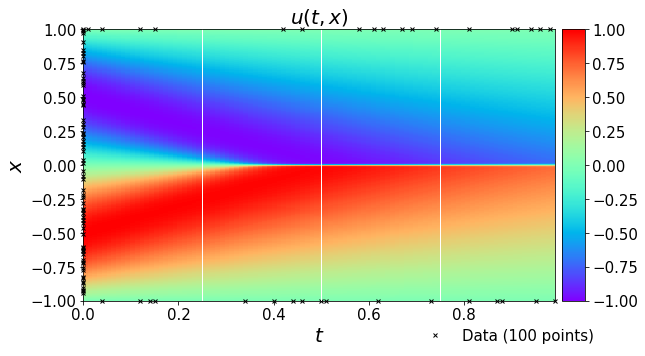

In [ ]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

# **Visualizations**

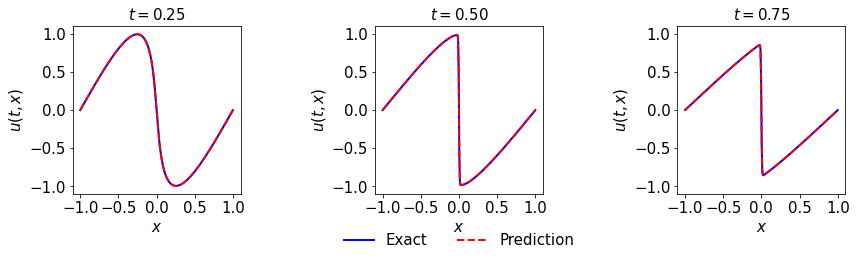

In [ ]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

Text(0.5, 1.0, 'test error')

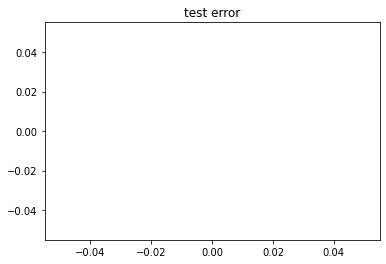

In [ ]:
import matplotlib

x_axis = [i for i in range(1,len(error_list)+1)]

plt.plot(x_axis, error_list)
plt.title("test error")